In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


(891, 12) {'PassengerId': 0, 'Survived': 0, 'Pclass': 0, 'Name': 0, 'Sex': 0, 'Age': 177, 'SibSp': 0, 'Parch': 0, 'Ticket': 0, 'Fare': 0, 'Cabin': 687, 'Embarked': 2}
Decision Tree (max_depth=2) ROC AUC: 0.8051383399209486


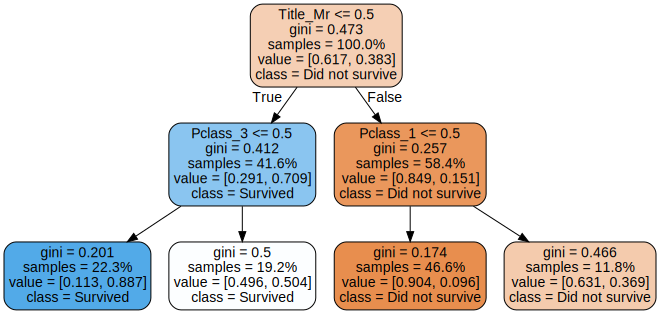

Fitting 4 folds for each of 9 candidates, totalling 36 fits
Best params (DecisionTree): {'dt__max_depth': 3}
Best CV ROC AUC: 0.8663659467395037


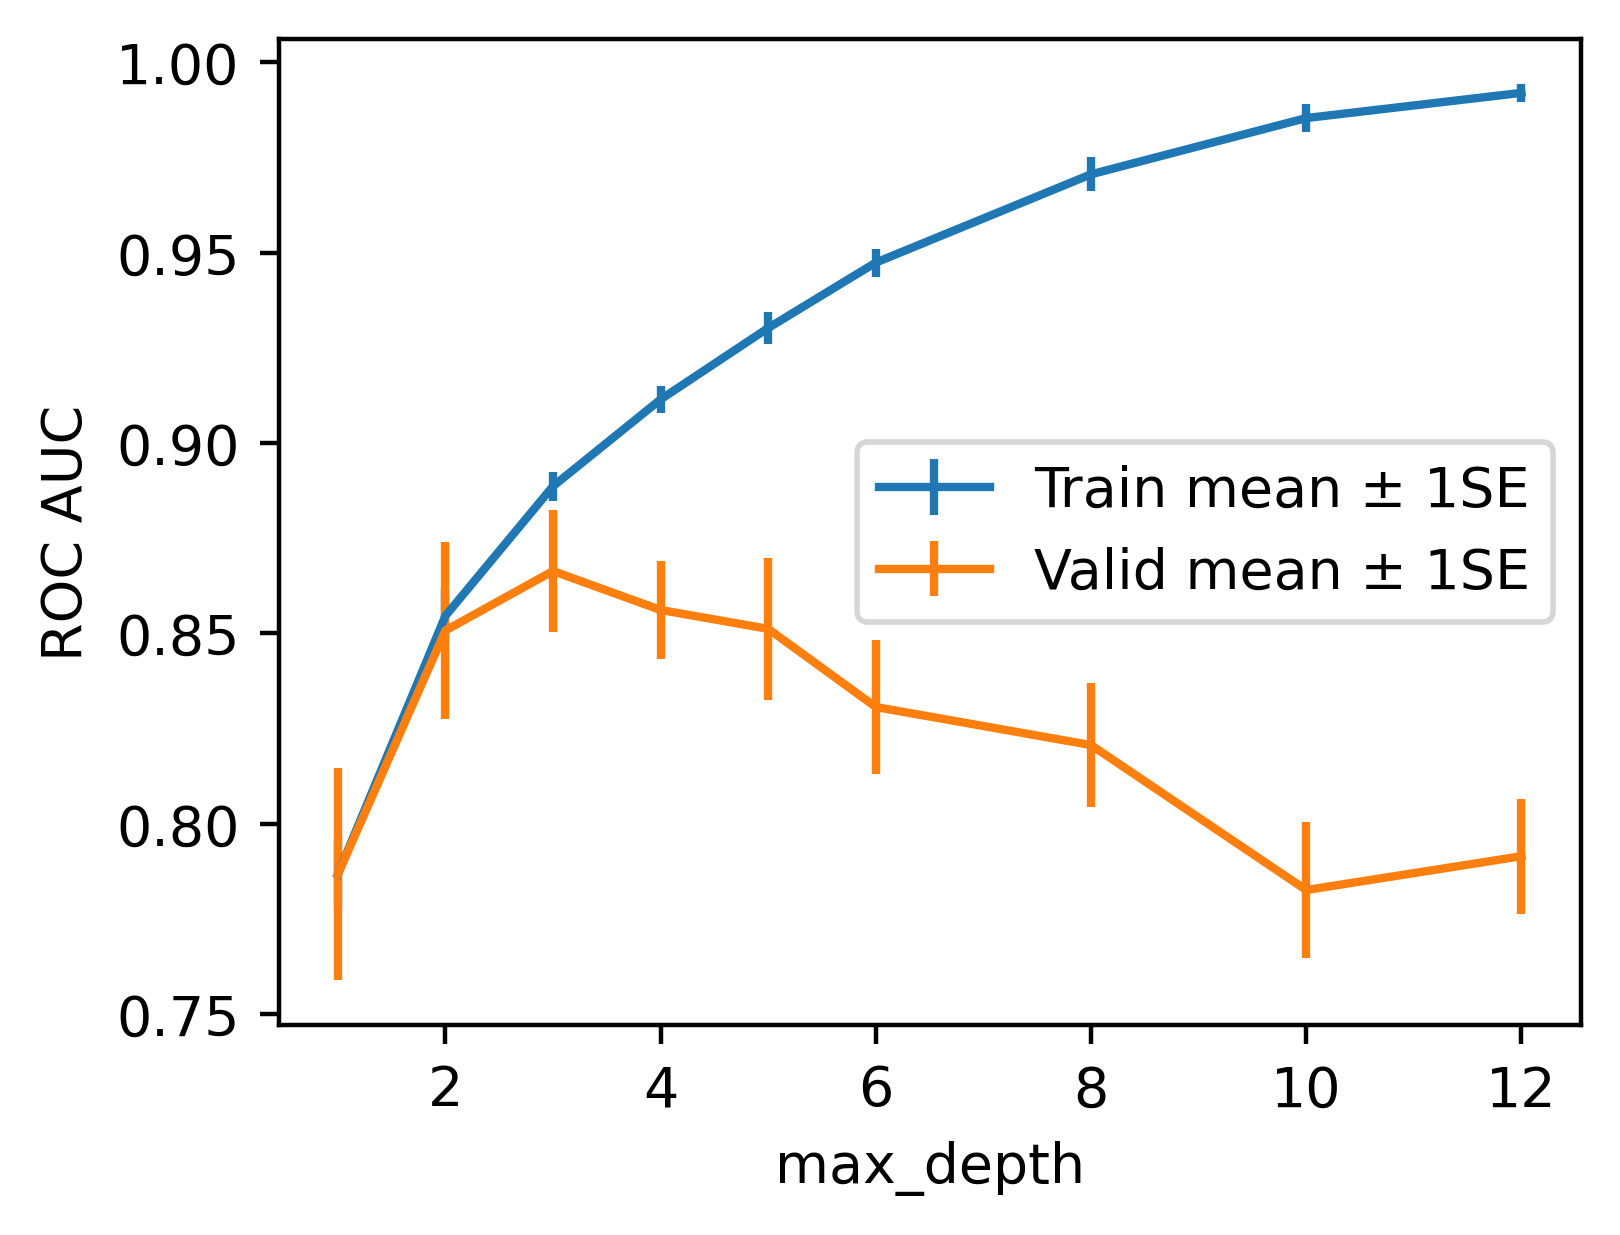

DecisionTree (best) Valid ROC AUC: 0.8484189723320157
RandomForest (n_estimators=10, max_depth=3) Valid ROC AUC: 0.8474967061923585
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best params (RF): {'rf__n_estimators': 60}
Best CV ROC AUC (RF): 0.8611829657707084


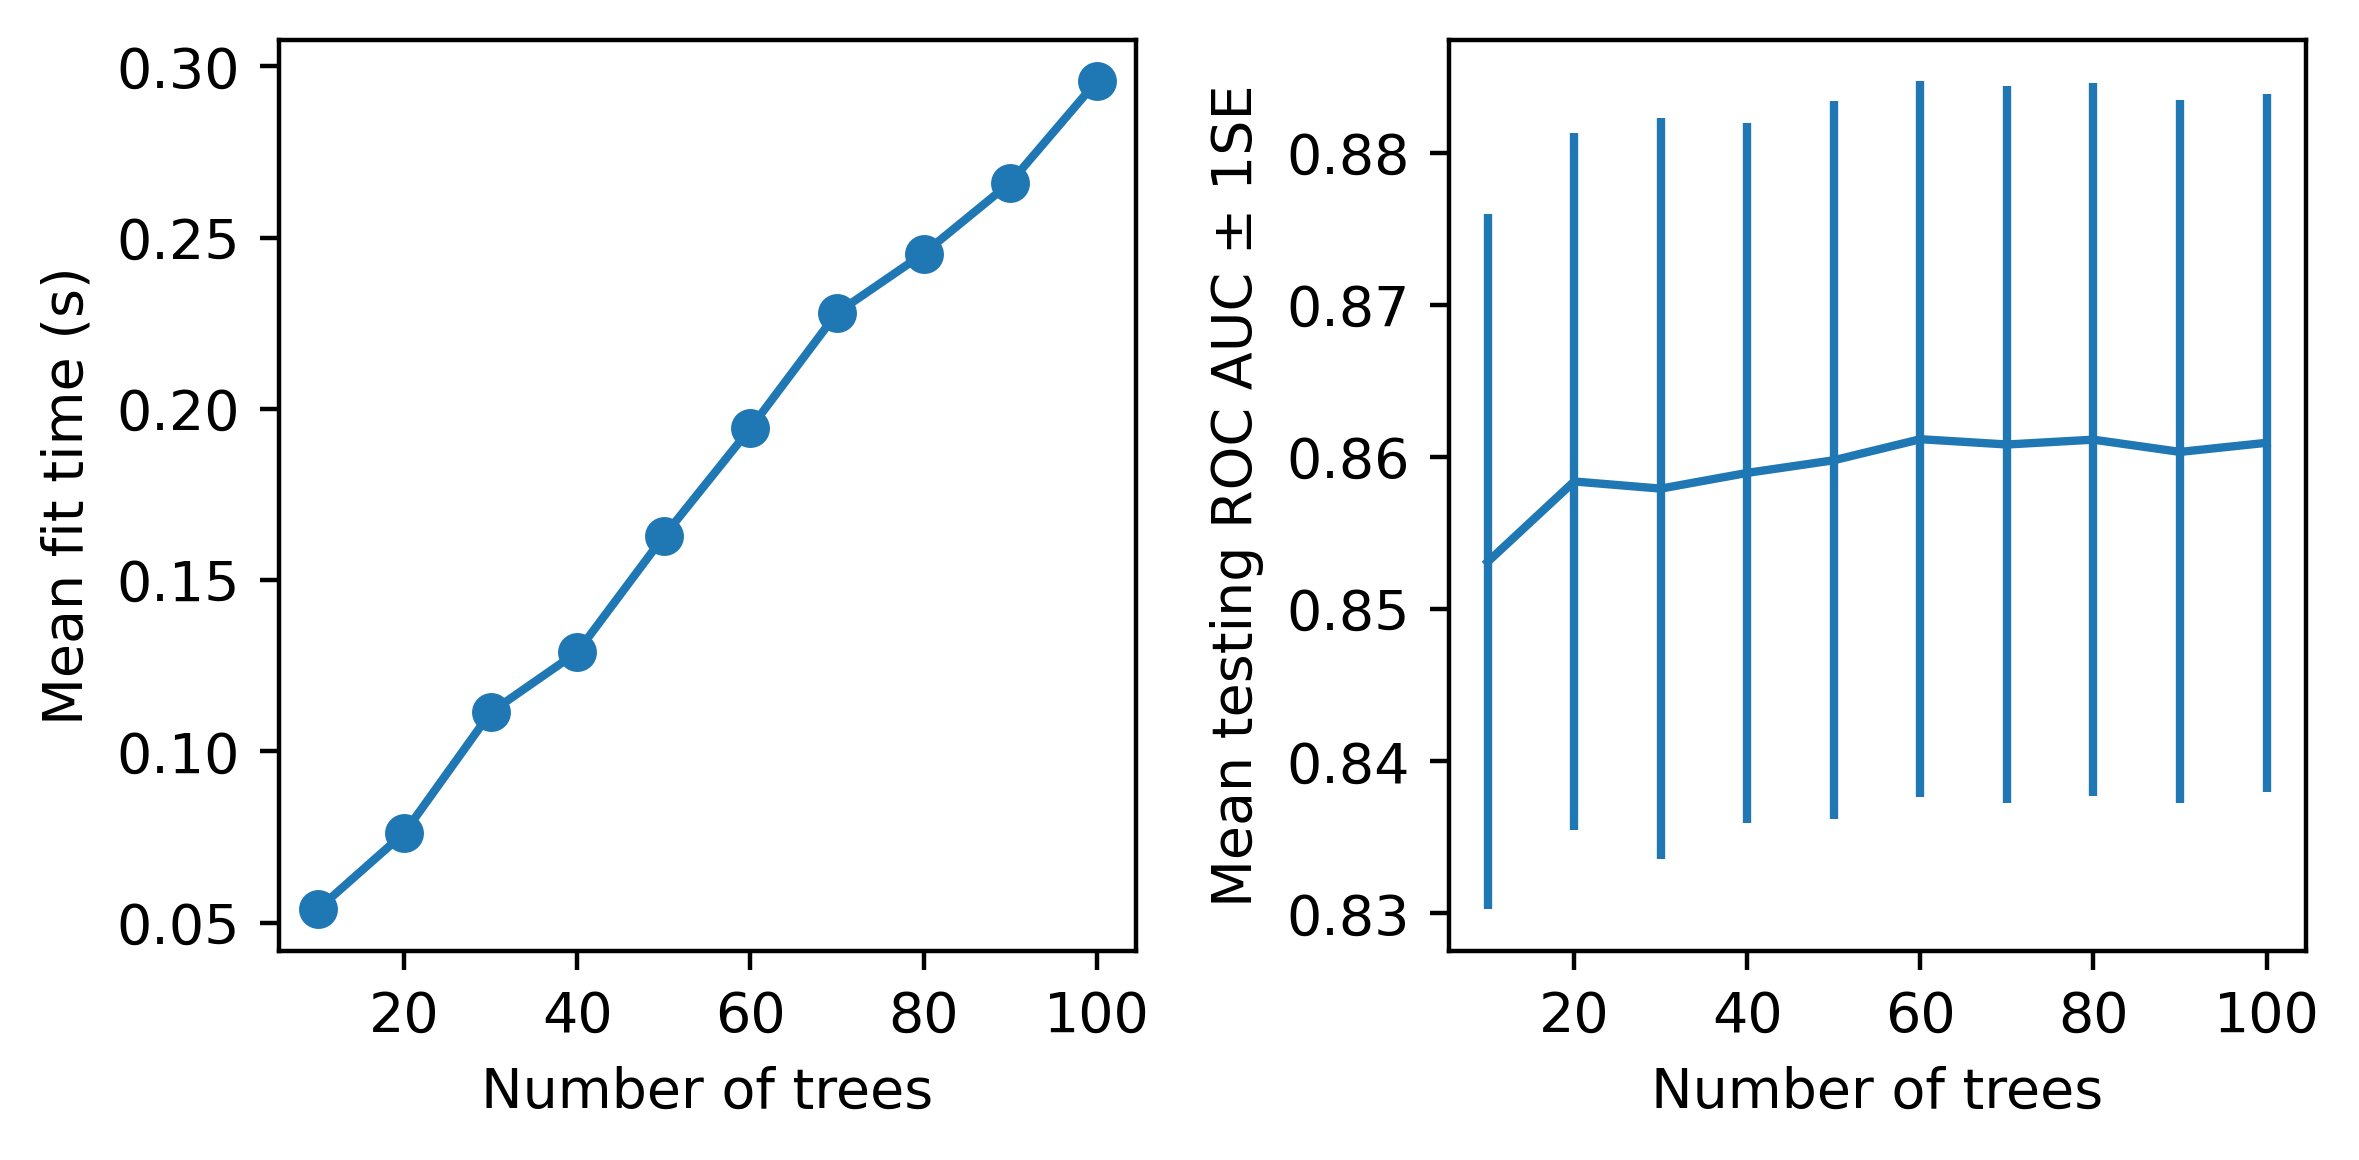

RandomForest (best) Valid ROC AUC: 0.8440711462450594


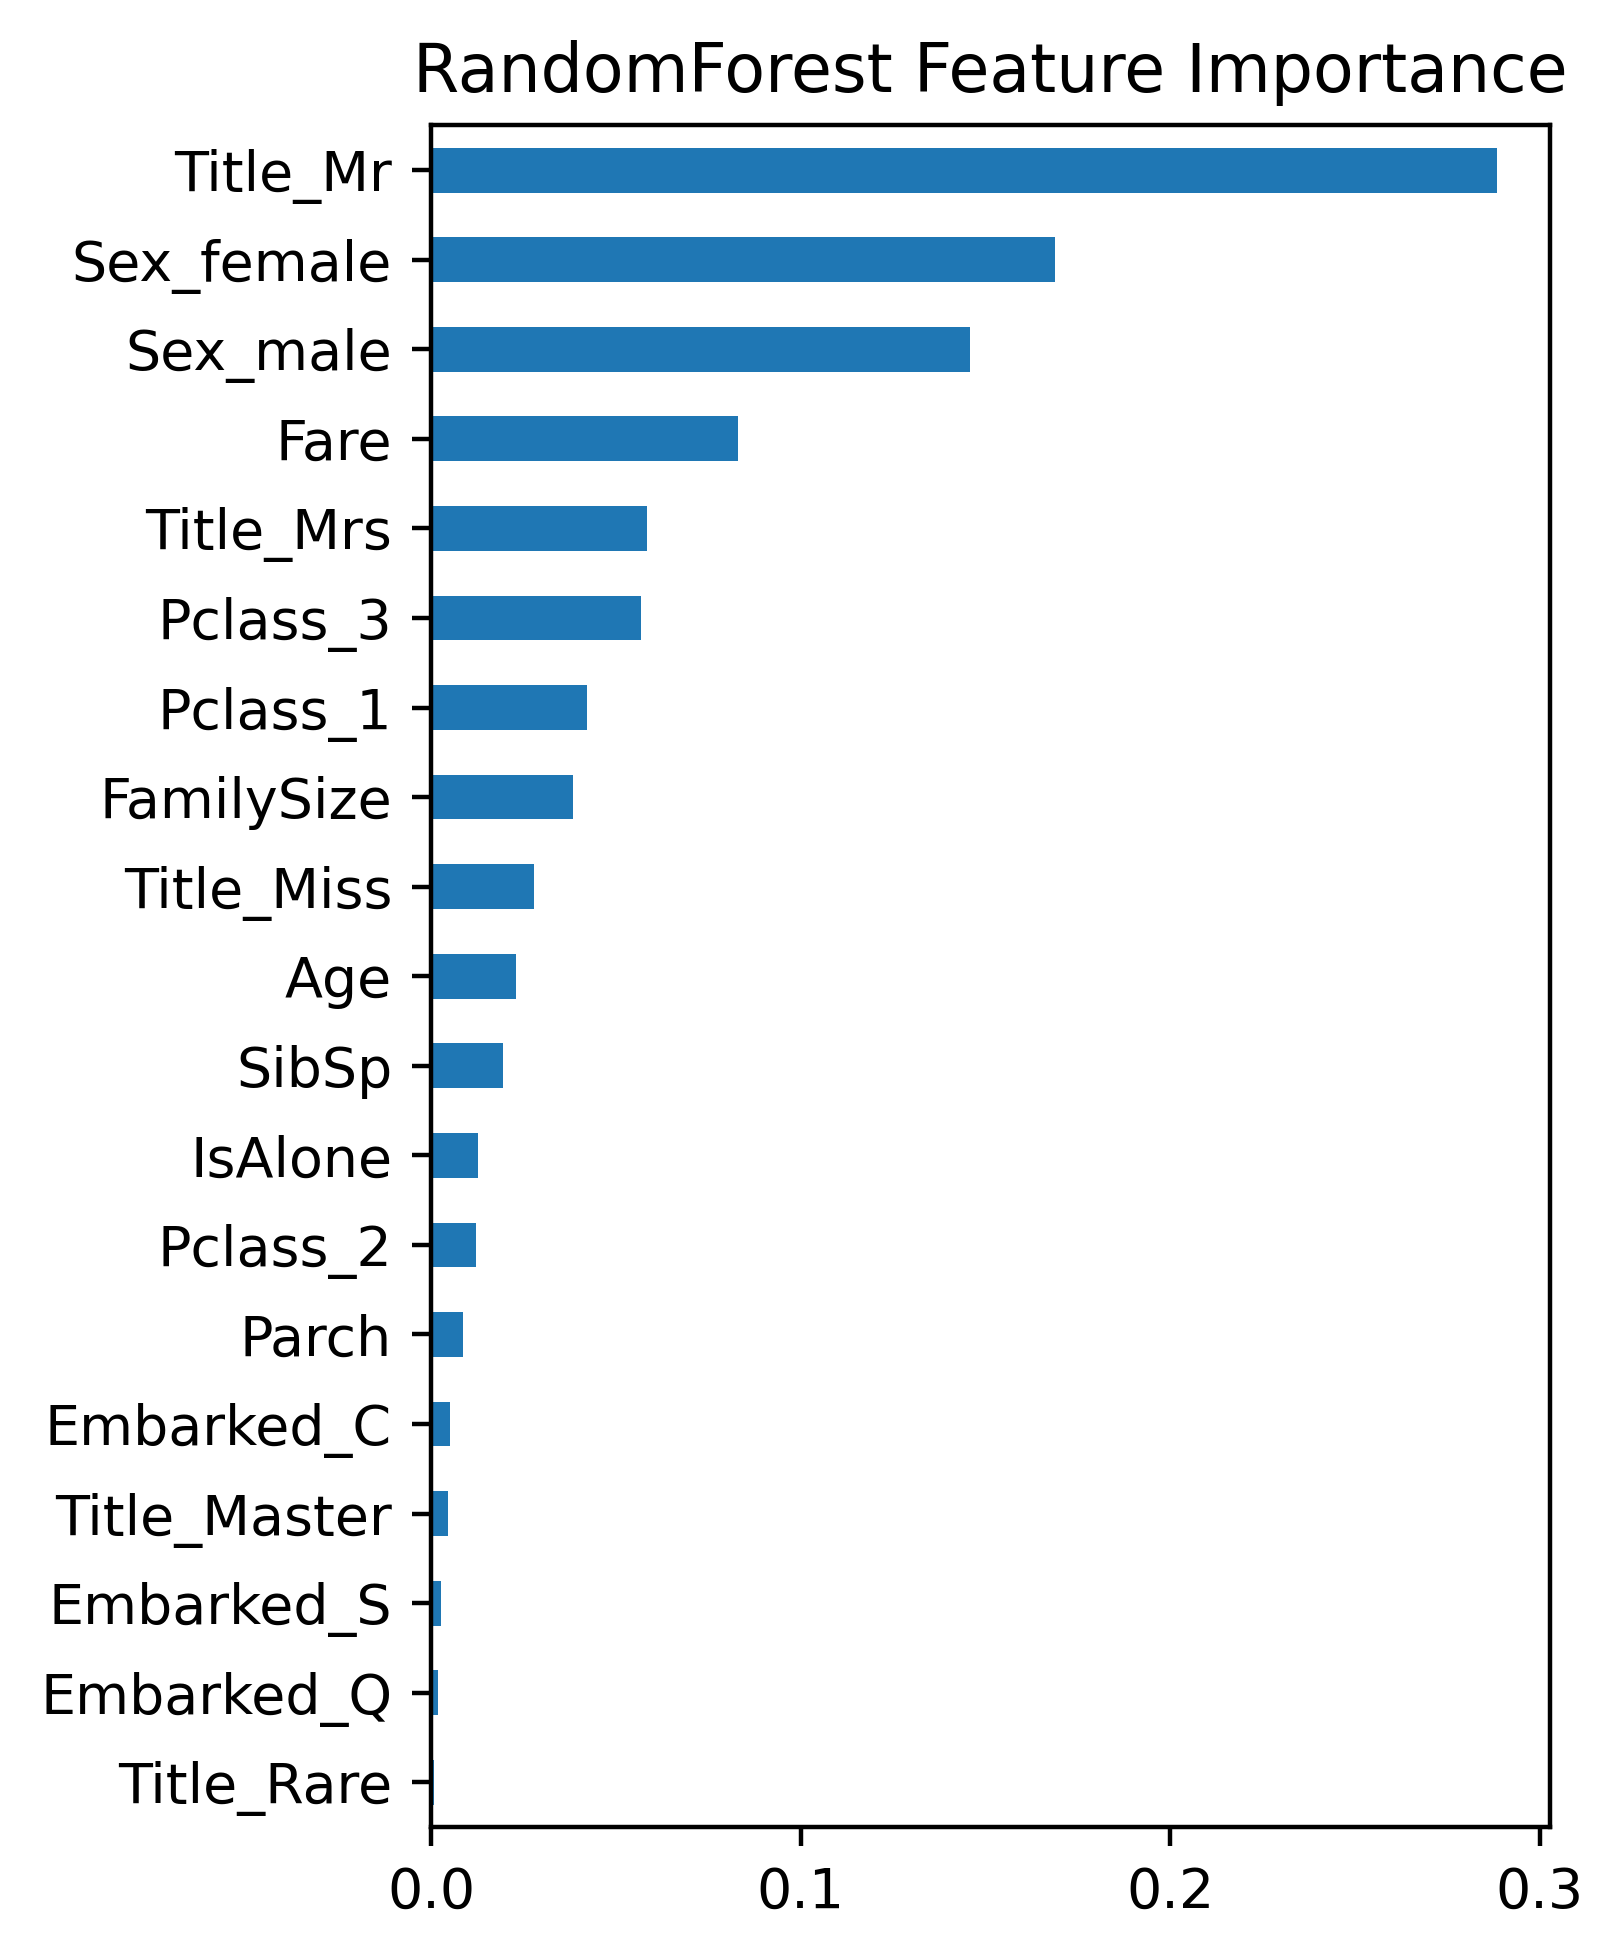

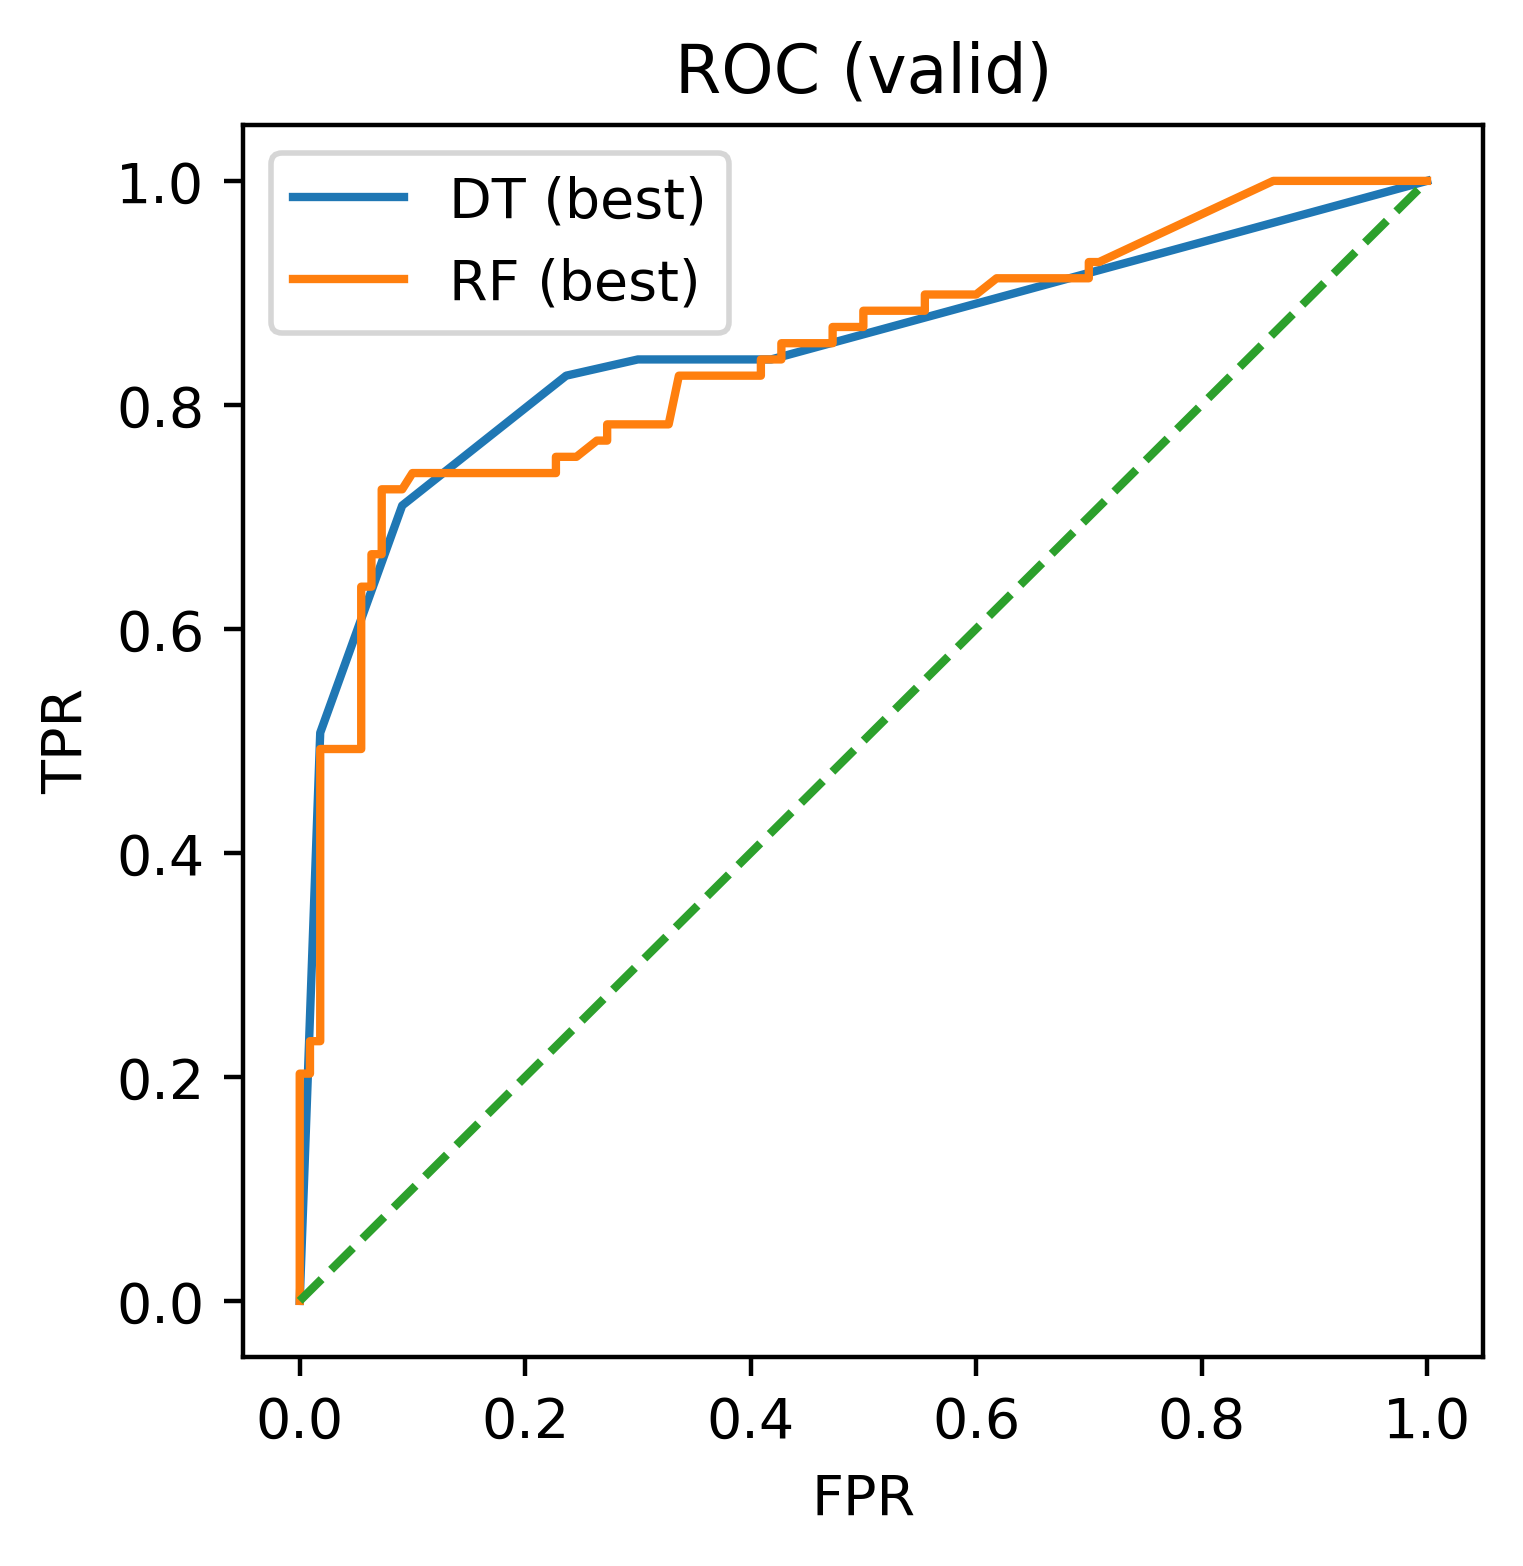

In [3]:
# =========================
# 0) CÀI & IMPORT GÓI (Step 1 trong tài liệu)
# =========================
# !pip install graphviz --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier


TRAIN_PATH = "/kaggle/input/titanic/train.csv"
TEST_PATH  = "/kaggle/input/titanic/test.csv"

df  = pd.read_csv(TRAIN_PATH)
dft = pd.read_csv(TEST_PATH)

# Khảo sát nhanh
print(df.shape, df.isna().sum().to_dict())

# Chọn các trường cơ bản từ mô tả đề bài
# Có thể thêm feature engineering đơn giản: FamilySize, IsAlone, Title
def add_basic_features(ddf: pd.DataFrame) -> pd.DataFrame:
    out = ddf.copy()
    # Family size
    out["FamilySize"] = out["SibSp"] + out["Parch"] + 1
    out["IsAlone"] = (out["FamilySize"] == 1).astype(int)
    # Title (Mr, Mrs, Miss, Master, Rare)
    out["Title"] = out["Name"].str.extract(r',\s*([^\.]+)\.', expand=False)
    rare_titles = ["Lady","Countess","Capt","Col","Don","Dr","Major","Rev",
                   "Sir","Jonkheer","Dona"]
    out["Title"] = out["Title"].replace({
        "Mlle":"Miss","Ms":"Miss","Mme":"Mrs"
    })
    out["Title"] = out["Title"].replace({t:"Rare" for t in rare_titles})
    return out

df  = add_basic_features(df)
dft = add_basic_features(dft)

# Biến mục tiêu và biến đầu vào
target_col = "Survived"
# Giữ các biến hữu ích, bỏ ID/chuỗi không cần thiết (Ticket, Cabin có thể quá thưa)
feature_cols = [
    "Pclass","Sex","Age","SibSp","Parch","Fare","Embarked",
    "FamilySize","IsAlone","Title"
]

X = df[feature_cols].copy()
y = df[target_col].copy()
X_test_submit = dft[feature_cols].copy()
test_passenger_ids = dft["PassengerId"].values

# =========================
# 2) TIỀN XỬ LÝ & TÁCH TẬP (Step 3 trong tài liệu)
# =========================
# Cột số & cột phân loại
num_cols  = ["Age","SibSp","Parch","Fare","FamilySize","IsAlone"]
cat_cols  = ["Pclass","Sex","Embarked","Title"]  # Pclass cũng coi là categorical
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # scikit-learn >= 1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # scikit-learn < 1.2

numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols),
    ]
)
# Train/Test split (giữ random_state như tài liệu)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=24, stratify=y
)

# =========================
# 3) CÂY QUYẾT ĐỊNH (Step 4–5 trong tài liệu)
# =========================
dt_clf = tree.DecisionTreeClassifier(max_depth=2, random_state=24)

dt_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("dt", dt_clf)
])

dt_pipe.fit(X_train, y_train)

# Đánh giá nhanh ROC AUC
y_valid_proba_dt = dt_pipe.predict_proba(X_valid)[:,1]
print("Decision Tree (max_depth=2) ROC AUC:", roc_auc_score(y_valid, y_valid_proba_dt))

# -------- VẼ CÂY BẰNG GRAPHVIZ ----------
# Lấy tên feature sau one-hot để xuất cây
ohe = dt_pipe.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
num_names = num_cols
cat_names = list(ohe.get_feature_names_out(cat_cols))
all_feature_names = num_names + cat_names

# Trích mô hình cây thật sự (sau preprocess) bằng cách refit trên ma trận đã biến đổi
# (cách đơn giản để export_graphviz với đúng feature names)
from sklearn import set_config
set_config(transform_output="pandas")  # giúp lấy DataFrame sau transform

X_train_tx = preprocess.fit_transform(X_train)  # fit lại preprocess để lấy cột
true_dt = tree.DecisionTreeClassifier(max_depth=2, random_state=24)
true_dt.fit(X_train_tx, y_train)

dot = tree.export_graphviz(
    true_dt,
    out_file=None,
    filled=True,
    rounded=True,
    feature_names=all_feature_names,
    proportion=True,
    class_names=["Did not survive","Survived"]
)
graph = graphviz.Source(dot)
display(graph)  # Hiển thị cây (Hình 2.1 tương tự)

# =========================
# 4) GRIDSEARCHCV: TỐI ƯU max_depth (Step 2–3 của Nhiệm vụ 2)
# =========================
params_dt = {"dt__max_depth":[1,2,3,4,5,6,8,10,12]}
base_dt = tree.DecisionTreeClassifier(random_state=24)

grid_dt = Pipeline(steps=[("prep", preprocess), ("dt", base_dt)])

cv_dt = GridSearchCV(
    grid_dt, param_grid=params_dt,
    scoring="roc_auc", cv=4, refit=True, return_train_score=True, verbose=1
)
cv_dt.fit(X_train, y_train)

print("Best params (DecisionTree):", cv_dt.best_params_)
print("Best CV ROC AUC:", cv_dt.best_score_)

# VẼ biểu đồ mean ± 1SE (như tài liệu)
cvdf = pd.DataFrame(cv_dt.cv_results_)
k = 4
fig, ax = plt.subplots(figsize=(4.2,3.2))
ax.errorbar(cvdf["param_dt__max_depth"], cvdf["mean_train_score"],
            yerr=cvdf["std_train_score"]/np.sqrt(k), label="Train mean ± 1SE")
ax.errorbar(cvdf["param_dt__max_depth"], cvdf["mean_test_score"],
            yerr=cvdf["std_test_score"]/np.sqrt(k), label="Valid mean ± 1SE")
ax.set_xlabel("max_depth"); ax.set_ylabel("ROC AUC"); ax.legend(); plt.show()

# Đánh giá trên hold-out valid
y_valid_proba_dt_best = cv_dt.predict_proba(X_valid)[:,1]
print("DecisionTree (best) Valid ROC AUC:", roc_auc_score(y_valid, y_valid_proba_dt_best))

# =========================
# 5) RANDOM FOREST (Nhiệm vụ 3; Step 2–5)
# =========================
rf = RandomForestClassifier(
    n_estimators=10, criterion="gini", max_depth=3,
    min_samples_split=2, min_samples_leaf=1, max_features="sqrt",
    bootstrap=True, oob_score=False, random_state=4, n_jobs=-1
)

rf_pipe = Pipeline(steps=[("prep", preprocess), ("rf", rf)])
rf_pipe.fit(X_train, y_train)
y_valid_proba_rf = rf_pipe.predict_proba(X_valid)[:,1]
print("RandomForest (n_estimators=10, max_depth=3) Valid ROC AUC:",
      roc_auc_score(y_valid, y_valid_proba_rf))

# ---- GridSearch số cây (giống tài liệu) ----
rf_grid = {"rf__n_estimators": list(range(10,110,10))}
cv_rf = GridSearchCV(
    Pipeline(steps=[("prep", preprocess),
                   ("rf", RandomForestClassifier(
                       criterion="gini", max_depth=3,
                       min_samples_split=2, min_samples_leaf=1,
                       max_features="sqrt", bootstrap=True,
                       random_state=4, n_jobs=-1
                   ))]),
    param_grid=rf_grid, scoring="roc_auc",
    cv=4, refit=True, return_train_score=True, verbose=1
)
cv_rf.fit(X_train, y_train)

print("Best params (RF):", cv_rf.best_params_)
print("Best CV ROC AUC (RF):", cv_rf.best_score_)

# Biểu đồ (số cây vs thời gian fit & ROC AUC) — Hình 2.3 tương tự
rf_res = pd.DataFrame(cv_rf.cv_results_)
fig, axs = plt.subplots(1,2, figsize=(6,3))
axs[0].plot(rf_res["param_rf__n_estimators"], rf_res["mean_fit_time"], "-o")
axs[0].set_xlabel("Number of trees"); axs[0].set_ylabel("Mean fit time (s)")
axs[1].errorbar(rf_res["param_rf__n_estimators"], rf_res["mean_test_score"],
                yerr=rf_res["std_test_score"]/np.sqrt(4))
axs[1].set_xlabel("Number of trees"); axs[1].set_ylabel("Mean testing ROC AUC ± 1SE")
plt.tight_layout(); plt.show()

# Hold-out valid ROC AUC của mô hình RF tốt nhất
y_valid_proba_rf_best = cv_rf.predict_proba(X_valid)[:,1]
print("RandomForest (best) Valid ROC AUC:", roc_auc_score(y_valid, y_valid_proba_rf_best))

# =========================
# 6) FEATURE IMPORTANCE (Step 5 trong tài liệu)
# =========================
# Lấy model RF tốt nhất & tên cột sau preprocess để vẽ importance
best_rf_pipe = cv_rf.best_estimator_
best_rf = best_rf_pipe.named_steps["rf"]

# Fit riêng preprocess trên toàn train để lấy tên cột
preprocess_fitted = best_rf_pipe.named_steps["prep"]
ohe = preprocess_fitted.named_transformers_["cat"].named_steps["ohe"]
feat_names = num_cols + list(ohe.get_feature_names_out(cat_cols))

imp = pd.Series(best_rf.feature_importances_, index=feat_names).sort_values(ascending=True)
ax = imp.plot.barh(figsize=(4.2,5))
ax.set_title("RandomForest Feature Importance")
plt.tight_layout(); plt.show()

def plot_roc(y_true, p1, label):
    fpr, tpr, _ = roc_curve(y_true, p1)
    plt.plot(fpr, tpr, label=label)

plt.figure(figsize=(4,4))
plot_roc(y_valid, y_valid_proba_dt_best, "DT (best)")
plot_roc(y_valid, y_valid_proba_rf_best, "RF (best)")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (valid)"); plt.legend(); plt.show()
